In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
sf_data = pd.read_csv("./raw_data/sanfrancisco.csv")

In [3]:
raw_columns = list(sf_data)

In [4]:
unused_columns = ['snow_1h', 'snow_24h', 'rain_24h', 'rain_1h', 'snow_3h', 'rain_today', 'snow_today', 'weather_icon', 'weather_id', 'sea_level', 'grnd_level', 'lat', 'lon', 'city_id', 'city_name']

In [5]:
used_columns = columns = list(set(raw_columns) - set(unused_columns))

In [6]:
sf_data.head(10)

,dt,dt_iso,city_id,city_name,lat,lon,temp,temp_min,temp_max,pressure,...,rain_today,snow_1h,snow_3h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1349096400,2012-10-01 13:00:00 +0000 UTC,5391959,NaN,NaN,NaN,289.48,282.15,301.15,1009,...,NaN,NaN,NaN,NaN,NaN,0,300,Drizzle,light intensity drizzle,09n
1,1349096400,2012-10-01 13:00:00 +0000 UTC,5391959,NaN,NaN,NaN,289.48,282.15,301.15,1009,...,NaN,NaN,NaN,NaN,NaN,0,500,Rain,light rain,10n
2,1349186400,2012-10-02 14:00:00 +0000 UTC,5391959,NaN,NaN,NaN,289.13,282.15,301.15,1015,...,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01d
3,1349190000,2012-10-02 15:00:00 +0000 UTC,5391959,NaN,NaN,NaN,290.73,283.15,302.15,1016,...,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01d
4,1349193600,2012-10-02 16:00:00 +0000 UTC,5391959,NaN,NaN,NaN,293.02,287.15,307.15,1011,...,NaN,NaN,NaN,NaN,NaN,0,721,Haze,haze,50d
5,1349197200,2012-10-02 17:00:00 +0000 UTC,5391959,NaN,NaN,NaN,296.18,290.15,307.15,1001,...,NaN,NaN,NaN,NaN,NaN,0,721,Haze,haze,50d
6,1349200800,2012-10-02 18:00:00 +0000 UTC,5391959,NaN,NaN,NaN,299.66,293.71,305.93,1009,...,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d
7,1349204400,2012-10-02 19:00:00 +0000 UTC,5391959,NaN,NaN,NaN,300.03,293.15,308.15,1000,...,NaN,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04d
8,1349208000,2012-10-02 20:00:00 +0000 UTC,5391959,NaN,NaN,NaN,301.07,293.15,308.71,1007,...,NaN,NaN,NaN,NaN,NaN,0,721,Haze,haze,50d
9,1349211600,2012-10-02 21:00:00 +0000 UTC,5391959,NaN,NaN,NaN,302.29,295.15,308.71,1007,...,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04d


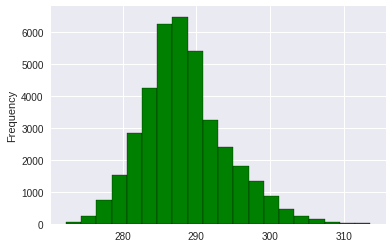

In [7]:

sf_data.temp.plot.hist(color='green', bins=20, edgecolor='black')
weather_description_columns = list(set(sf_data['weather_description']))
weather_main_columns = list(set(sf_data['weather_main']))

In [8]:
def cleanup(raw_data, used_columns):
    data = raw_data.loc[:, used_columns] 
    print("fill_na")
    data['rain_3h'] = data['rain_3h'].fillna(0)
    print("drop_duplicates")
    data.drop_duplicates('dt', inplace=True)
    print("add_new_dada")
    data = add_new_data(data)
    
    data = data.apply(transform_datetime, axis=1)
    
    unused_columns  = ['dt_iso', 'weather_main', 'weather_description', 'dt_datetime']
    
    data = data.drop(unused_columns, axis=1)
    data = data.reset_index(drop=True)
    return data

def add_new_data(data):
    data['dt_datetime'] =  pd.to_datetime(data['dt_iso'], format='%Y-%m-%d %H:%M:%S +%f %Z')
    weather_description_columns = list(set(data['weather_description']))
    weather_main_columns = list(set(data['weather_main']))
    data = transform_categorical_data(data, weather_description_columns,weather_main_columns)

    return data

def transform_categorical_data(data, weather_description_columns, weather_main_columns):
    for column in weather_description_columns:
        data[column] = data['weather_description'] == column
        data[column] = data[column].astype(int)
        
    for column in weather_main_columns:
        data[column] = data['weather_main'] == column
        data[column] = data[column].astype(int)
    return data
    
def transform_datetime(current_data):
    for month in range(1, 12):
        current_data['month_{}'.format(month)] = 1 if current_data['dt_datetime'].month == month else 0

    current_data['year'] =  current_data['dt_datetime'].year
    current_data['dayofweek'] = current_data['dt_datetime'].dayofweek
    current_data['dayofyear'] = current_data['dt_datetime'].dayofyear
    current_data['hourofday'] = current_data['dt_datetime'].hour
    return current_data


In [9]:
sf_data2 = cleanup(sf_data[1:], used_columns)


fill_na
drop_duplicates
add_new_dada


In [10]:
sf_data2.columns

Index(['temp', 'dt', 'rain_3h', 'pressure', 'clouds_all', 'wind_deg',
       'temp_min', 'temp_max', 'wind_speed', 'humidity', 'overcast clouds',
       'heavy intensity drizzle', 'fog', 'thunderstorm with heavy rain',
       'smoke', 'sky is clear', 'shower rain', 'light intensity drizzle',
       'few clouds', 'light intensity shower rain', 'light rain', 'haze',
       'drizzle', 'proximity thunderstorm with rain', 'light snow',
       'moderate rain', 'very heavy rain', 'thunderstorm with light drizzle',
       'thunderstorm with light rain', 'heavy intensity rain', 'SQUALLS',
       'thunderstorm', 'Sky is Clear', 'thunderstorm with rain',
       'broken clouds', 'heavy snow', 'mist', 'proximity thunderstorm',
       'proximity thunderstorm with drizzle', 'scattered clouds',
       'proximity shower rain', 'Haze', 'Fog', 'Rain', 'Mist', 'Snow',
       'Drizzle', 'Squall', 'Clouds', 'Thunderstorm', 'Smoke', 'Clear',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'mont

In [11]:
sf_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33442 entries, 0 to 33441
Data columns (total 67 columns):
temp                                   33442 non-null float64
dt                                     33442 non-null int64
rain_3h                                33442 non-null float64
pressure                               33442 non-null int64
clouds_all                             33442 non-null int64
wind_deg                               33442 non-null int64
temp_min                               33442 non-null float64
temp_max                               33442 non-null float64
wind_speed                             33442 non-null int64
humidity                               33442 non-null int64
overcast clouds                        33442 non-null int64
heavy intensity drizzle                33442 non-null int64
fog                                    33442 non-null int64
thunderstorm with heavy rain           33442 non-null int64
smoke                                  3344

In [12]:
def add_target_data(data):
    data['target_temp'] = data['temp'][1:].append(pd.Series([np.nan]) , ignore_index=True)
    return data

In [13]:
sf_data3 = add_target_data(sf_data2)

In [14]:
# def add_previous_datum(raw_data):
#     data = raw_data.copy()
#     diff_columns = list(set(raw_data.columns) - set(['dt', 'dt_iso', 'dt_datetime']))
#     maximum_prev = 2 *  24
#     data = data.apply(add_previous_data, args=(diff_columns, data, maximum_prev), axis=1)
#     return data

# def add_previous_data(current_data,  diff_columns, raw_data, maximum_prev):
#     index = current_data.name
#     print(index)
#     if index == 0:
#         return current_data
#     prev_right = index - 1
#     prev_left = index - maximum_prev if index - maximum_prev > 0 else 0
       
#     while prev_left <= prev_right:
#         current_data = add_diff_data(current_data, raw_data.iloc[prev_left], maximum_prev, diff_columns)
#         prev_left += 1
#     return current_data

# def add_diff_data(current_data, prev_data, maximum_prev, diff_columns):
#     diff = int(pd.Timedelta(current_data['dt_datetime'] - prev_data['dt_datetime']).seconds/ 3600)
#     if diff > 0 and diff < maximum_prev:
#         for diff_column in diff_columns:
#             column_name = '{}_{}_ago'.format(diff_column, diff)
#             current_data[column_name] = prev_data[diff_column]
#     return current_data

# # add new data by merging np array and adding dummy data 
# #[NALL, NALL, data1, data2]


In [15]:
hour_diffs =  [1,2,3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48]

In [16]:
def add_diff_data(raw_data):
    data = raw_data.copy()
    diff_columns = list(set(raw_data.columns) - set(['dt', 'dt_iso', 'dt_datetime', 'target_temp', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'year', 'dayofyear', 'dayofweek', 'hourofday', 'temp_min', 'temp_max'] + weather_description_columns))
    maximum_prev = 2 *  24
    for i in hour_diffs:
        for column in diff_columns:
            data['{}_{}_ago'.format(column, i)] = pd.Series(np.repeat(np.nan, i)).append(data[column][:-i] , ignore_index=True)
    return data    

In [17]:
sf_data4 = add_diff_data(sf_data3)

In [18]:
set(sf_data4.columns)

{'Clear',
 'Clear_12_ago',
 'Clear_15_ago',
 'Clear_18_ago',
 'Clear_1_ago',
 'Clear_21_ago',
 'Clear_24_ago',
 'Clear_27_ago',
 'Clear_2_ago',
 'Clear_30_ago',
 'Clear_33_ago',
 'Clear_36_ago',
 'Clear_39_ago',
 'Clear_3_ago',
 'Clear_42_ago',
 'Clear_45_ago',
 'Clear_48_ago',
 'Clear_6_ago',
 'Clear_9_ago',
 'Clouds',
 'Clouds_12_ago',
 'Clouds_15_ago',
 'Clouds_18_ago',
 'Clouds_1_ago',
 'Clouds_21_ago',
 'Clouds_24_ago',
 'Clouds_27_ago',
 'Clouds_2_ago',
 'Clouds_30_ago',
 'Clouds_33_ago',
 'Clouds_36_ago',
 'Clouds_39_ago',
 'Clouds_3_ago',
 'Clouds_42_ago',
 'Clouds_45_ago',
 'Clouds_48_ago',
 'Clouds_6_ago',
 'Clouds_9_ago',
 'Drizzle',
 'Drizzle_12_ago',
 'Drizzle_15_ago',
 'Drizzle_18_ago',
 'Drizzle_1_ago',
 'Drizzle_21_ago',
 'Drizzle_24_ago',
 'Drizzle_27_ago',
 'Drizzle_2_ago',
 'Drizzle_30_ago',
 'Drizzle_33_ago',
 'Drizzle_36_ago',
 'Drizzle_39_ago',
 'Drizzle_3_ago',
 'Drizzle_42_ago',
 'Drizzle_45_ago',
 'Drizzle_48_ago',
 'Drizzle_6_ago',
 'Drizzle_9_ago',
 'Fog',
 '

In [19]:
def remove_diff_null_data(raw_data):
    data = raw_data[48:-1]
    return data


In [20]:
sf_data5 = remove_diff_null_data(sf_data4)

In [21]:
sf_data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33442 entries, 0 to 33441
Columns: 392 entries, temp to humidity_48_ago
dtypes: float64(329), int64(63)
memory usage: 100.0 MB


In [22]:
sf_data5['target_temp'].tail()

33436    286.48
33437    287.98
33438    289.79
33439    290.53
33440    290.15
Name: target_temp, dtype: float64

In [23]:
sf_data5['year'].value_counts()

2017    8184
2016    7759
2013    7307
2014    4521
2015    3573
2012    2049
Name: year, dtype: int64

In [24]:
corr_data = sf_data5.corr()


In [25]:
corr_data['target_temp'].sort_values(ascending=False)

target_temp          1.000000
temp                 0.970162
temp_1_ago           0.908717
temp_min             0.889365
temp_max             0.870034
temp_2_ago           0.824332
temp_21_ago          0.813713
temp_24_ago          0.812773
temp_45_ago          0.729116
temp_3_ago           0.725692
temp_48_ago          0.715624
temp_18_ago          0.629526
temp_27_ago          0.614730
temp_42_ago          0.573016
temp_6_ago           0.432761
temp_15_ago          0.404335
temp_30_ago          0.375512
temp_39_ago          0.370124
temp_12_ago          0.265815
temp_9_ago           0.264466
hourofday            0.259144
month_7              0.252517
temp_36_ago          0.237463
temp_33_ago          0.233645
humidity_12_ago      0.219516
month_8              0.218840
month_9              0.218013
humidity_36_ago      0.216244
humidity_9_ago       0.206200
humidity_33_ago      0.194744
                       ...   
Rain_1_ago          -0.104331
Rain_3_ago          -0.104374
Rain      

In [26]:
sf_data5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33393 entries, 48 to 33440
Columns: 392 entries, temp to humidity_48_ago
dtypes: float64(329), int64(63)
memory usage: 99.9 MB


In [27]:
y_label = sf_data5['target_temp']
sf_data6 = sf_data5.drop(['target_temp'], axis=1)

## Modeling

In [28]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):

        return X[self.attribute_names].values

In [29]:
sf_data6.columns

Index(['temp', 'dt', 'rain_3h', 'pressure', 'clouds_all', 'wind_deg',
       'temp_min', 'temp_max', 'wind_speed', 'humidity',
       ...
       'Mist_48_ago', 'Thunderstorm_48_ago', 'wind_speed_48_ago',
       'Drizzle_48_ago', 'Squall_48_ago', 'Clear_48_ago', 'Clouds_48_ago',
       'Snow_48_ago', 'Smoke_48_ago', 'humidity_48_ago'],
      dtype='object', length=391)

In [30]:
category_columns = []
for i in range(1, 12):
    category_columns.append('month_{}'.format(i))
for i in hour_diffs:
    for column in weather_main_columns:
        category_columns.append('{}_{}_ago'.format(column, i))
category_columns += weather_main_columns
numercial_columns = list(set(sf_data6) - set(category_columns))

In [31]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(category_columns))
])

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(numercial_columns)),
    ('scalar', StandardScaler())
])



In [32]:

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
    ("pca", PCA())
    
])

sf_train = full_pipeline.fit_transform(sf_data6)

In [33]:
sf_train[0]

array([  2.01636175e+00,  -1.06769611e+00,   6.96363303e-01,
        -1.06766073e+00,   7.95291491e-01,  -1.69069896e-01,
        -2.74817202e+00,   6.97000969e-01,  -4.03516348e-01,
        -4.03570602e-01,  -8.14995958e-01,  -1.22374181e-02,
        -2.06593653e+00,  -6.45306912e-02,  -2.56056211e-01,
         4.19383123e-01,  -3.07420640e+00,  -1.04027622e+00,
        -9.81748629e-01,   1.65539559e+00,   4.20133477e-01,
        -1.04027622e+00,  -1.03797880e+00,  -2.06630034e+00,
        -5.86830193e-01,  -1.42305934e+00,   8.93583251e-01,
        -3.44584297e-03,  -1.04010427e+00,   6.04050668e-01,
        -4.77610484e-02,   9.94781033e-01,  -8.61480476e-02,
        -6.45306912e-02,  -1.06777079e+00,   1.24275249e+00,
         2.45264079e+00,   6.96893403e-01,  -4.34763041e-02,
        -9.97590749e-02,  -3.75785804e-01,  -1.77842023e-01,
         1.87691149e+00,   1.44565425e+00,  -2.06620082e+00,
        -2.56665287e-01,   9.05474684e-01,   1.24265291e+00,
         7.87820990e-01,

In [34]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
sgd_clf = SGDClassifier(random_state=42)
# sgd_clf.fit(sf_train, y_label)


In [50]:
sf_train

array([[  2.01636175e+00,  -1.06769611e+00,   6.96363303e-01, ...,
         -4.25318063e-08,   2.33028730e-13,   1.33524025e-14],
       [  2.19859092e+00,  -1.06769611e+00,   5.97686092e-01, ...,
         -2.44188013e-08,   1.50453910e-13,   2.04127500e-14],
       [  2.41235975e+00,  -1.06769611e+00,   7.95040514e-01, ...,
          2.41841341e-08,  -5.40671482e-14,   3.76913881e-14],
       ..., 
       [ -7.22332337e-01,  -1.04019620e+00,  -1.06009106e+00, ...,
         -1.34378672e-09,  -3.05252778e-17,   2.01582603e-15],
       [ -8.34473362e-01,  -1.04019620e+00,  -1.86924419e+00, ...,
          3.81442781e-09,  -3.89195445e-15,   1.96620586e-15],
       [ -1.00093270e+00,  -1.04019620e+00,  -1.27718092e+00, ...,
          2.00471728e-09,  -1.74590044e-15,   1.14862987e-15]])

In [48]:
y_label.shape

(33393,)

In [51]:
cross_val_score(sgd_clf, sf_train, y_label, cv=3, scoring='neg_log_loss')

ValueError: Unknown label type: (array([ 272.98,  273.14,  273.39, ...,  313.24,  313.25,  313.62]),)